In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from igraph import Graph, RainbowPalette, plot
import cairo

In [2]:
def self_join_df(df):
    # Ensure that the DataFrame has 'user_id' and 'business_id' columns
    if 'user_id' not in df.columns or 'business_id' not in df.columns:
        raise ValueError("DataFrame must contain 'user_id' and 'business_id' columns.")
    
    # Perform a self-join on 'user_id'
    joined_df = df.merge(df, on='user_id', suffixes=('_left', '_right'))
    
    # Filter rows where 'business_id' is different
    result_df = joined_df[joined_df['business_id_left'] != joined_df['business_id_right']]
    
    # Drop unnecessary columns
    result_df = result_df[['user_id', 'business_id_left', 'business_id_right', 'stars_left', 'stars_right']]

    # Reset the index
    result_df.reset_index(drop=True, inplace=True)
    
    return result_df

In [3]:
# Load the restaurant dataset
restaurants = pd.read_csv('data/tucson_restaurants.csv')

# Count the number of categories in each row
restaurants['numcat'] = restaurants['categories'].str.split(',').apply(len)

# filter out rows with 3 categories
df_res = restaurants[restaurants['numcat'] == 3].copy(deep=True)
df_res.reset_index(drop=True, inplace=True)
print('shape .::.', df_res.shape)

# Create a new column for each category
df_res['category1'] = df_res['categories'].str.split(',').apply(lambda x: x[0])
df_res['category2'] = df_res['categories'].str.split(',').apply(lambda x: x[1])
df_res['category3'] = df_res['categories'].str.split(',').apply(lambda x: x[2])

# Drop unnecessary columns
df_res = df_res[['business_id', 'name', 'stars', 'review_count', 'is_open', 'category1', 'category2', 'category3']]
df_res.head()

shape .::. (452, 7)


business_id                           name  stars  review_count  \
0  iNMdSi5bmvGSGeRQiUW4dw                        Wendy's    2.5            14   
1  UAi8nZY-tCA758y4_8Meuw         Fullylove’s Restaurant    4.5            25   
2  5N5K-B0pA3as6dvl_ha5BQ  Famous Sam's Restaurant & Bar    2.0            25   
3  lhsQkb5nhf-Kd5OvgB9MNg                  Sachiko Sushi    3.5           191   
4  XyGRDrgCK0z4CiA6nhwEaw       Persian Room Fine Dining    4.5           258   

   is_open    category1         category2                category3  
0        1    Fast Food           Burgers              Restaurants  
1        0        Vegan    American (New)              Restaurants  
2        0      Burgers       Restaurants   American (Traditional)  
3        1     Japanese       Restaurants               Sushi Bars  
4        1  Restaurants   Persian/Iranian            Mediterranean

In [4]:
restaurants['categories'].str.split(',').apply(len).sort_index().value_counts()

2     460
3     452
4     437
5     427
6     310
7     152
8      92
9      60
10     30
11     15
12     13
1       8
13      5
14      2
15      2
17      2
22      1
18      1
25      1
Name: categories, dtype: int64

In [5]:
# Load the review dataset
reviews = pd.read_csv('data/tucson_reviews.csv')

# Filter out rows that are not in the restaurant dataset
reviews_df = reviews[reviews['business_id'].isin(df_res['business_id'])].copy(deep=True)

# Reset the index
reviews_df.reset_index(drop=True, inplace=True)

print('Old shape .::.', reviews.shape)
print('New shape .::.', reviews_df.shape)

# Perform self join
joined_df = self_join_df(reviews_df)
# Save the DataFrame to a CSV file
# joined_df.to_csv('output/tucson_reviews_self_joined.csv', index=False)
print('Joined shape .::.', joined_df.shape)
joined_df.head()


Old shape .::. (191113, 9)
New shape .::. (22029, 9)
Joined shape .::. (54076, 5)


user_id        business_id_left       business_id_right  \
0  1yXp7EkfmcxXOomfHxTu-g  B10mqANgHvL8gBteo1UhAA  vzvm7_QXEDaMTxMOKLBNyQ   
1  1yXp7EkfmcxXOomfHxTu-g  B10mqANgHvL8gBteo1UhAA  36rz3AMPh8ETMJq7cTG2Rw   
2  1yXp7EkfmcxXOomfHxTu-g  B10mqANgHvL8gBteo1UhAA  6BZ1gasOkF1mNfmUxfYqhA   
3  1yXp7EkfmcxXOomfHxTu-g  B10mqANgHvL8gBteo1UhAA  dMGWB4TEfEhgInQefGimAw   
4  1yXp7EkfmcxXOomfHxTu-g  B10mqANgHvL8gBteo1UhAA  EwWcloIMj8zflH5Dc16-nw   

   stars_left  stars_right  
0           2            3  
1           2            2  
2           2            3  
3           2            5  
4           2            5

In [6]:
# Create an sample of the DataFrame with 5,000 rows and stars_left == stars_right
df_join_sample = joined_df[joined_df.stars_left == joined_df.stars_right].sample(5_000, random_state=42)
# Create a links dataframe 
links = df_join_sample[['business_id_left', 'business_id_right']].copy(deep=True)
links['weight'] = 5
links.columns = ['source', 'target', 'weight']
links.reset_index(drop=True, inplace=True)
# links.to_csv('output/links.csv', index=False)
links.head()

source                  target  weight
0  _uDhUdcNBtgiOXPGPWunoQ  Zg83olSjsdXAhE5EEy5IcQ       5
1  LIcsCCOYqBO9k2tiO4Mrow  YdZS3QkpjgHU2zIJ_bqy_A       5
2  wexGsdw5Wz85-hOBx9r2Tg  gwOiwfeHxBemcMV6u1dI_w       5
3  aDL_KdxbDRT5s51Jtn9V5g  q_fvK1U95dwKebz6JDRSxg       5
4  wLybne33jvVt6rs9ji8bww  t-abv5g6bjbYwLerN_4VKw       5

In [7]:
nodes = df_res.drop_duplicates().copy(deep=True)
nodes.reset_index(drop=True, inplace=True)
nodes.columns = ['business_id', 'business_name', 'stars', 'review_count', 'is_open', 'category1', 'category2', 'category3']
# get only business_id in links
nodes = nodes[nodes['business_id'].isin(links['source'])].copy(deep=True)
nodes.reset_index(drop=True, inplace=True)
# nodes.to_csv('output/nodes.csv', index=False)
nodes.head()

business_id                  business_name  stars  review_count  \
0  lhsQkb5nhf-Kd5OvgB9MNg                  Sachiko Sushi    3.5           191   
1  XyGRDrgCK0z4CiA6nhwEaw       Persian Room Fine Dining    4.5           258   
2  5Ce3lZksYVkCbrihqylVHQ                     Sushi Nara    4.5           159   
3  vzvm7_QXEDaMTxMOKLBNyQ                 Guilin Chinese    3.5           116   
4  KAk07Tbv0UsoY-s7RYfepg  C.I. Chu's Mongolian Barbeque    3.5           177   

   is_open    category1         category2       category3  
0        1     Japanese       Restaurants      Sushi Bars  
1        1  Restaurants   Persian/Iranian   Mediterranean  
2        1   Sushi Bars          Japanese     Restaurants  
3        0   Vegetarian           Chinese     Restaurants  
4        1  Restaurants          Barbeque       Mongolian

In [8]:
# Create a graph from the links and nodes
net = Graph.DataFrame(links, directed=False, use_vids=False, vertices=nodes)

In [9]:
print(net.summary())
# get node with degree 0
# degree_0 = [v.index for v in net.vs if v.degree() == 0]
# print('degree 0 .::.', degree_0)
# retrive the node with degree 0
# node_0 = net.vs[degree_0[5]]
# print('node 0 .::.', node_0)

IGRAPH UNW- 104 5000 -- 
+ attr: business_name (v), category1 (v), category2 (v), category3 (v), is_open (v), name (v), review_count (v), stars (v), weight (e)


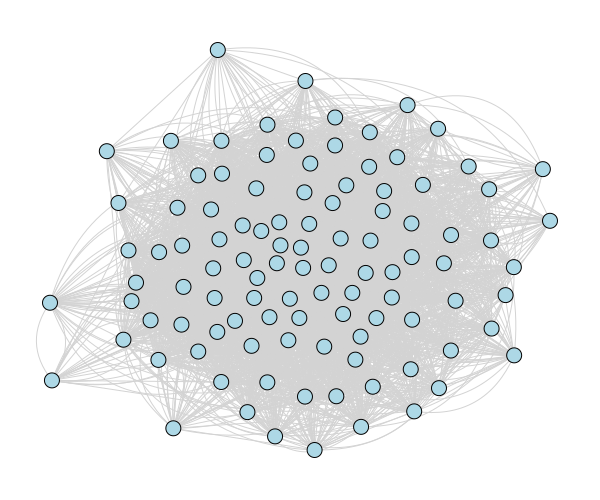

In [10]:
# remove node with degree 0
# net.delete_vertices(net.vs.select(_degree=0))

# change edge color
net.es['color'] = 'light gray'

# change vertex color
net.vs['color'] = 'light blue'

plot(net, edge_arrow_size=0.6, vertex_size=15, bbox=(600, 500), vertex_spacing=550, margin= 50)

In [11]:
# Get the number of nodes (vertices)
num_nodes = len(net.vs)

print("Number of nodes:", num_nodes)

# Get the number of edges
num_edges = len(net.es)

print("Number of edges:", num_edges)

Number of nodes: 104
Number of edges: 5000


In [12]:
print("Number of vertices:", net.vcount())
print("Number of edges:", net.ecount())
print("Density of the graph:", 2*net.ecount()/(net.vcount()*(net.vcount()-1)))
print("Diameter of the graph:", net.diameter())

Number of vertices: 104
Number of edges: 5000
Density of the graph: 0.9335324869305451
Diameter of the graph: 2


In [13]:
degrees = []
total = 0
n_vertices = net.vcount()

for n in range(n_vertices):
    neighbours = net.neighbors(n, mode='ALL')
    total += len(neighbours)
    degrees.append(len(neighbours))
    
print("Average degree:", total/n_vertices)
print("Maximum degree:", max(degrees))
print("Vertex ID with the maximum degree:", degrees.index(max(degrees)))

Average degree: 96.15384615384616
Maximum degree: 285
Vertex ID with the maximum degree: 17


In [14]:
cliques = net.cliques(min=3, max=3)
triangle_count = [0] * net.vcount()
for i, j, k in cliques:
    triangle_count[i] += 1
    triangle_count[j] += 1
    triangle_count[k] += 1

print("Average number of triangles:", sum(triangle_count)/net.vcount())
print("Maximum number of triangles:", max(triangle_count))
print("Vertex ID with the maximum number of triangles:", triangle_count.index(max(triangle_count)))

Average number of triangles: 619.0384615384615
Maximum number of triangles: 1559
Vertex ID with the maximum number of triangles: 17


Degree having the maximum number of vertices: 99
Number of vertices having the most abundant degree: 4


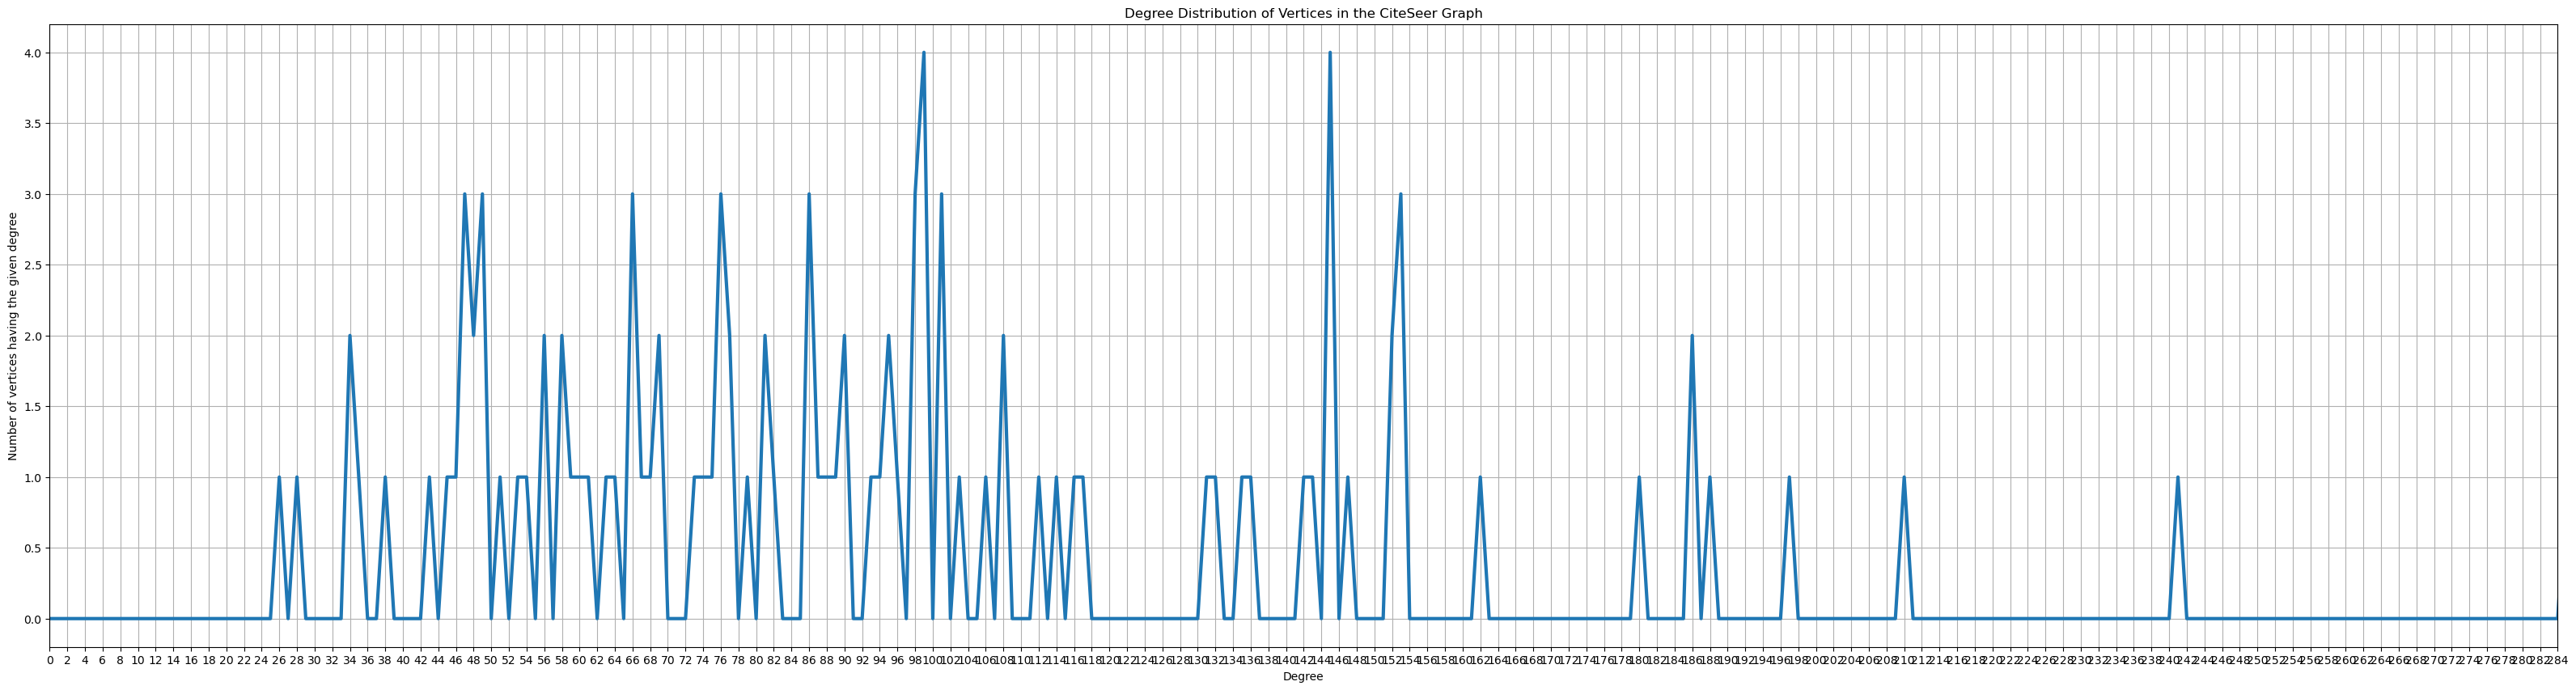

In [15]:
x = [x for x in range(max(degrees)+1)]
degree_counts = [0 for x in range(max(degrees)+1)]

for i in degrees:
    degree_counts[i] += 1

print("Degree having the maximum number of vertices:", degree_counts.index(max(degree_counts)))
print("Number of vertices having the most abundant degree:", max(degree_counts))

plt.figure(figsize=(40,10))
plt.plot(x, degree_counts, linewidth=3.0)
plt.ylabel('Number of vertices having the given degree')
plt.xlabel('Degree')
plt.title('Degree Distribution of Vertices in the CiteSeer Graph')

plt.xlim(0,100)
plt.xticks(np.arange(min(x), max(x)+1, 2.0))
plt.grid(True)
# plt.savefig('degree_distribution.png', bbox_inches='tight')
plt.show()


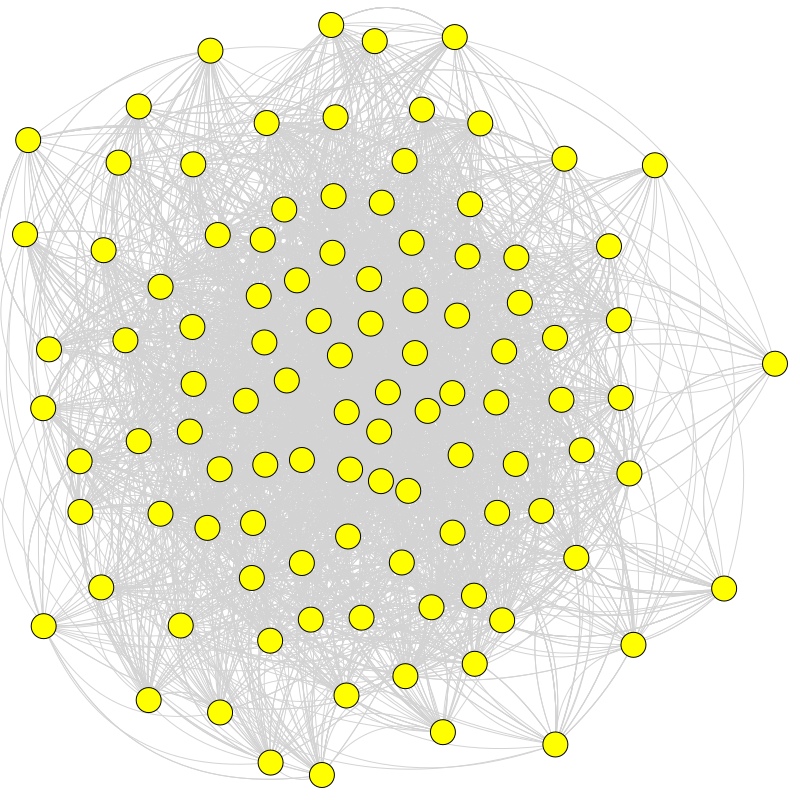

In [16]:
visual_style = {}

# Define colors used for outdegree visualization
colours = ['#fecc5c', '#a31a1c']

# Set bbox and margin
visual_style["bbox"] = (800,800)
visual_style["margin"] = 25

# Set vertex colours
visual_style["vertex_color"] = 'yellow'

# Set vertex size
visual_style["vertex_size"] = 25

# Set vertex spacing
visual_style["vertex_spacing"] = 150


# Don't curve the edges
visual_style["edge_curved"] = True

# Set the layout
my_layout = net.layout_fruchterman_reingold()
visual_style["layout"] = my_layout

# Plot the graph
plot(net, **visual_style)

IGRAPH UNW- 104 2431 -- 
+ attr: business_name (v), category1 (v), category2 (v), category3 (v), color (v), is_open (v), name (v), review_count (v), stars (v), weight (e)


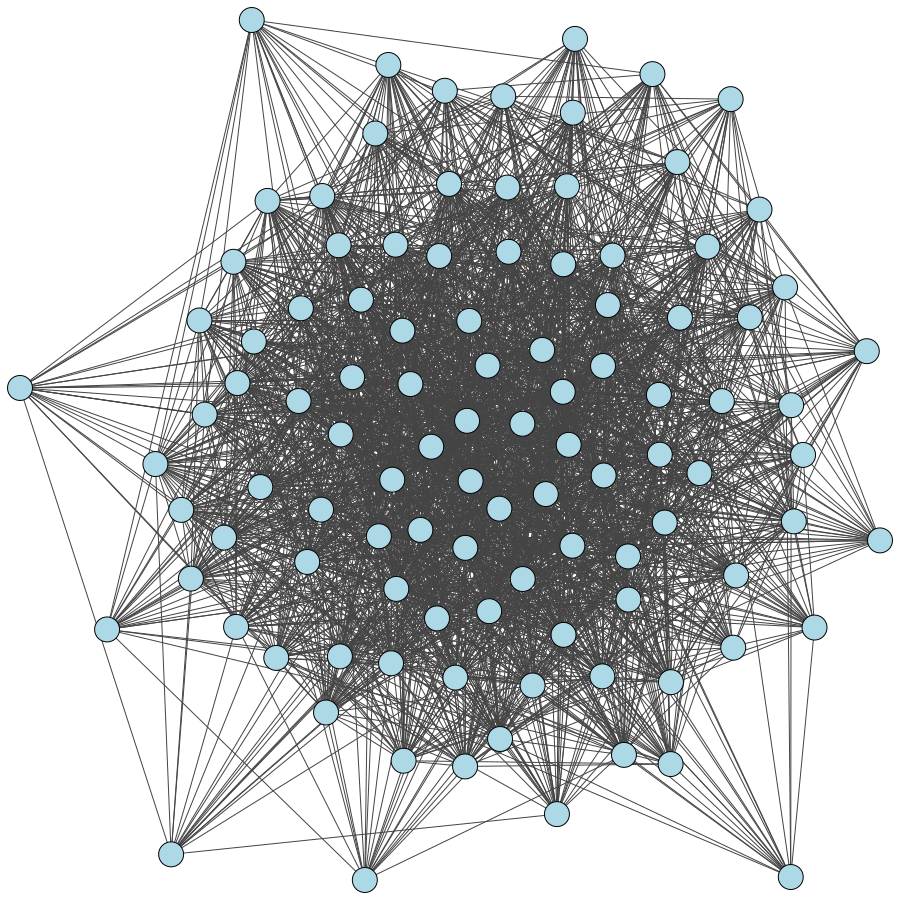

In [17]:
net_simp = net.simplify(multiple=True, loops=False, combine_edges=dict(weight="sum"))

print(net_simp.summary())
plot(net_simp, edge_arrow_size=0.2, vertex_size=25, bbox=(900, 900), vertex_spacing=250)

In [18]:
# Density: The proportion of present edges from all possible edges in the network
edge_density = net.density(loops=False)
print(f"Density: {edge_density:0.4f}")
print(f"or... {net.ecount() / (net.vcount() * (net.vcount() - 1)):0.4f}")

Density: 0.4539
or... 0.2269


In [19]:
# Diameter: longest geodesic distance (eccentricity) between any two vertices in the network
diameter_undirected = net.diameter(directed=False, weights=None)
print(f"Undirected diameter: {diameter_undirected}")
diameter_directed = net.diameter(directed=True, weights=None)
print(f"Directed diameter: {diameter_directed}")
diameter_weighted = net.diameter(directed=False, weights="weight")
print(f"Weighted undirected diameter: {diameter_weighted}")

Undirected diameter: 2
Directed diameter: 2
Weighted undirected diameter: 15.0


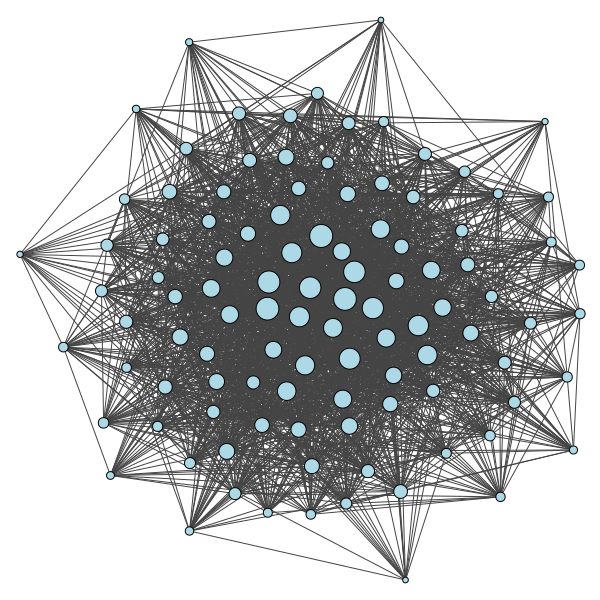

In [20]:
# Node degrees: how many edges are connected to a node
# The mode="ALL" parameter means that it calculates the total degree, considering both incoming and outgoing edges for directed graphs
deg = net.degree(mode="ALL")

# plot the network with node size proportional to degree
plot(net, vertex_size=[d * .3 for d in deg])

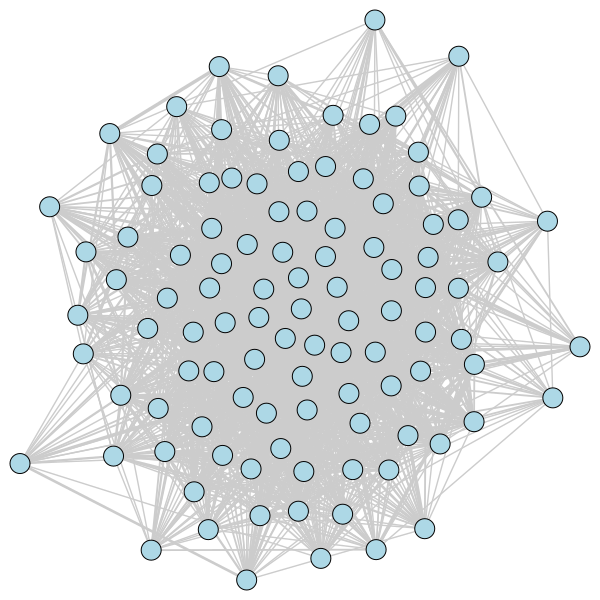

In [21]:

# Set edge color to gray, and the node color to orange
visual_style = {}
# Set edge width based on weight
visual_style["edge_width"] = [1 + weight / 12 for weight in net.es["weight"]]
# Change arrow size and edge color
visual_style["edge_arrow_size"] = 0.2
visual_style["edge_color"] = "gray80"

plot(net, **visual_style)

In [22]:
# Community detection based on edge betweenness (Newman-Girvan)
# High-betweenness edges are removed sequentially (recalculating at each step) and the best partitioning of the network is selected.
communities = net.community_edge_betweenness() 
communities = communities.as_clustering() # just for ease of use

# coloring the nodes based on the community they belong to
num_communities = len(communities)
palette = RainbowPalette(n=num_communities)
for i, community in enumerate(communities):
    net.vs[community]["color"] = i
    community_edges = net.es.select(_within=community)
    community_edges["color"] = i

In [44]:
community_membership = net.community_multilevel()

# Choose a community index for which you want to get the nodes
community_index = 0  # Replace with the index of the desired community

# Get the nodes that belong to the specified community
nodes_in_community = [v.index for v in net.vs if community_membership.membership[v.index] == community_index]

# Print the nodes in the community
print("Nodes in Community:", nodes_in_community)

Nodes in Community: [0, 22, 26, 31, 37, 47, 52, 78, 80, 82, 87, 89, 95]


In [45]:
community_nodes = {}

# Iterate through community memberships and collect nodes for each community
for community_index in range(max(community_membership.membership) + 1):
    nodes_in_community = [v.index for v in net.vs if community_membership.membership[v.index] == community_index]
    community_nodes[community_index] = nodes_in_community

# Print the nodes in each community
for community_index, nodes_in_community in community_nodes.items():
    print(f"Community {community_index}: Nodes {nodes_in_community}")

Community 0: Nodes [0, 22, 26, 31, 37, 47, 52, 78, 80, 82, 87, 89, 95]
Community 1: Nodes [1, 7, 8, 10, 12, 13, 14, 17, 28, 29, 30, 32, 33, 34, 43, 46, 54, 55, 58, 60, 64, 65, 66, 67, 72, 74, 75, 76, 93, 94, 98, 102]
Community 2: Nodes [2, 4, 9, 11, 15, 16, 18, 21, 35, 36, 38, 40, 41, 42, 44, 49, 50, 51, 53, 59, 69, 77, 79, 83, 85, 86, 88, 91, 92, 96, 99, 101]
Community 3: Nodes [3, 5, 6, 19, 20, 23, 24, 25, 27, 39, 45, 48, 56, 57, 61, 62, 63, 68, 70, 71, 73, 81, 84, 90, 97, 100, 103]


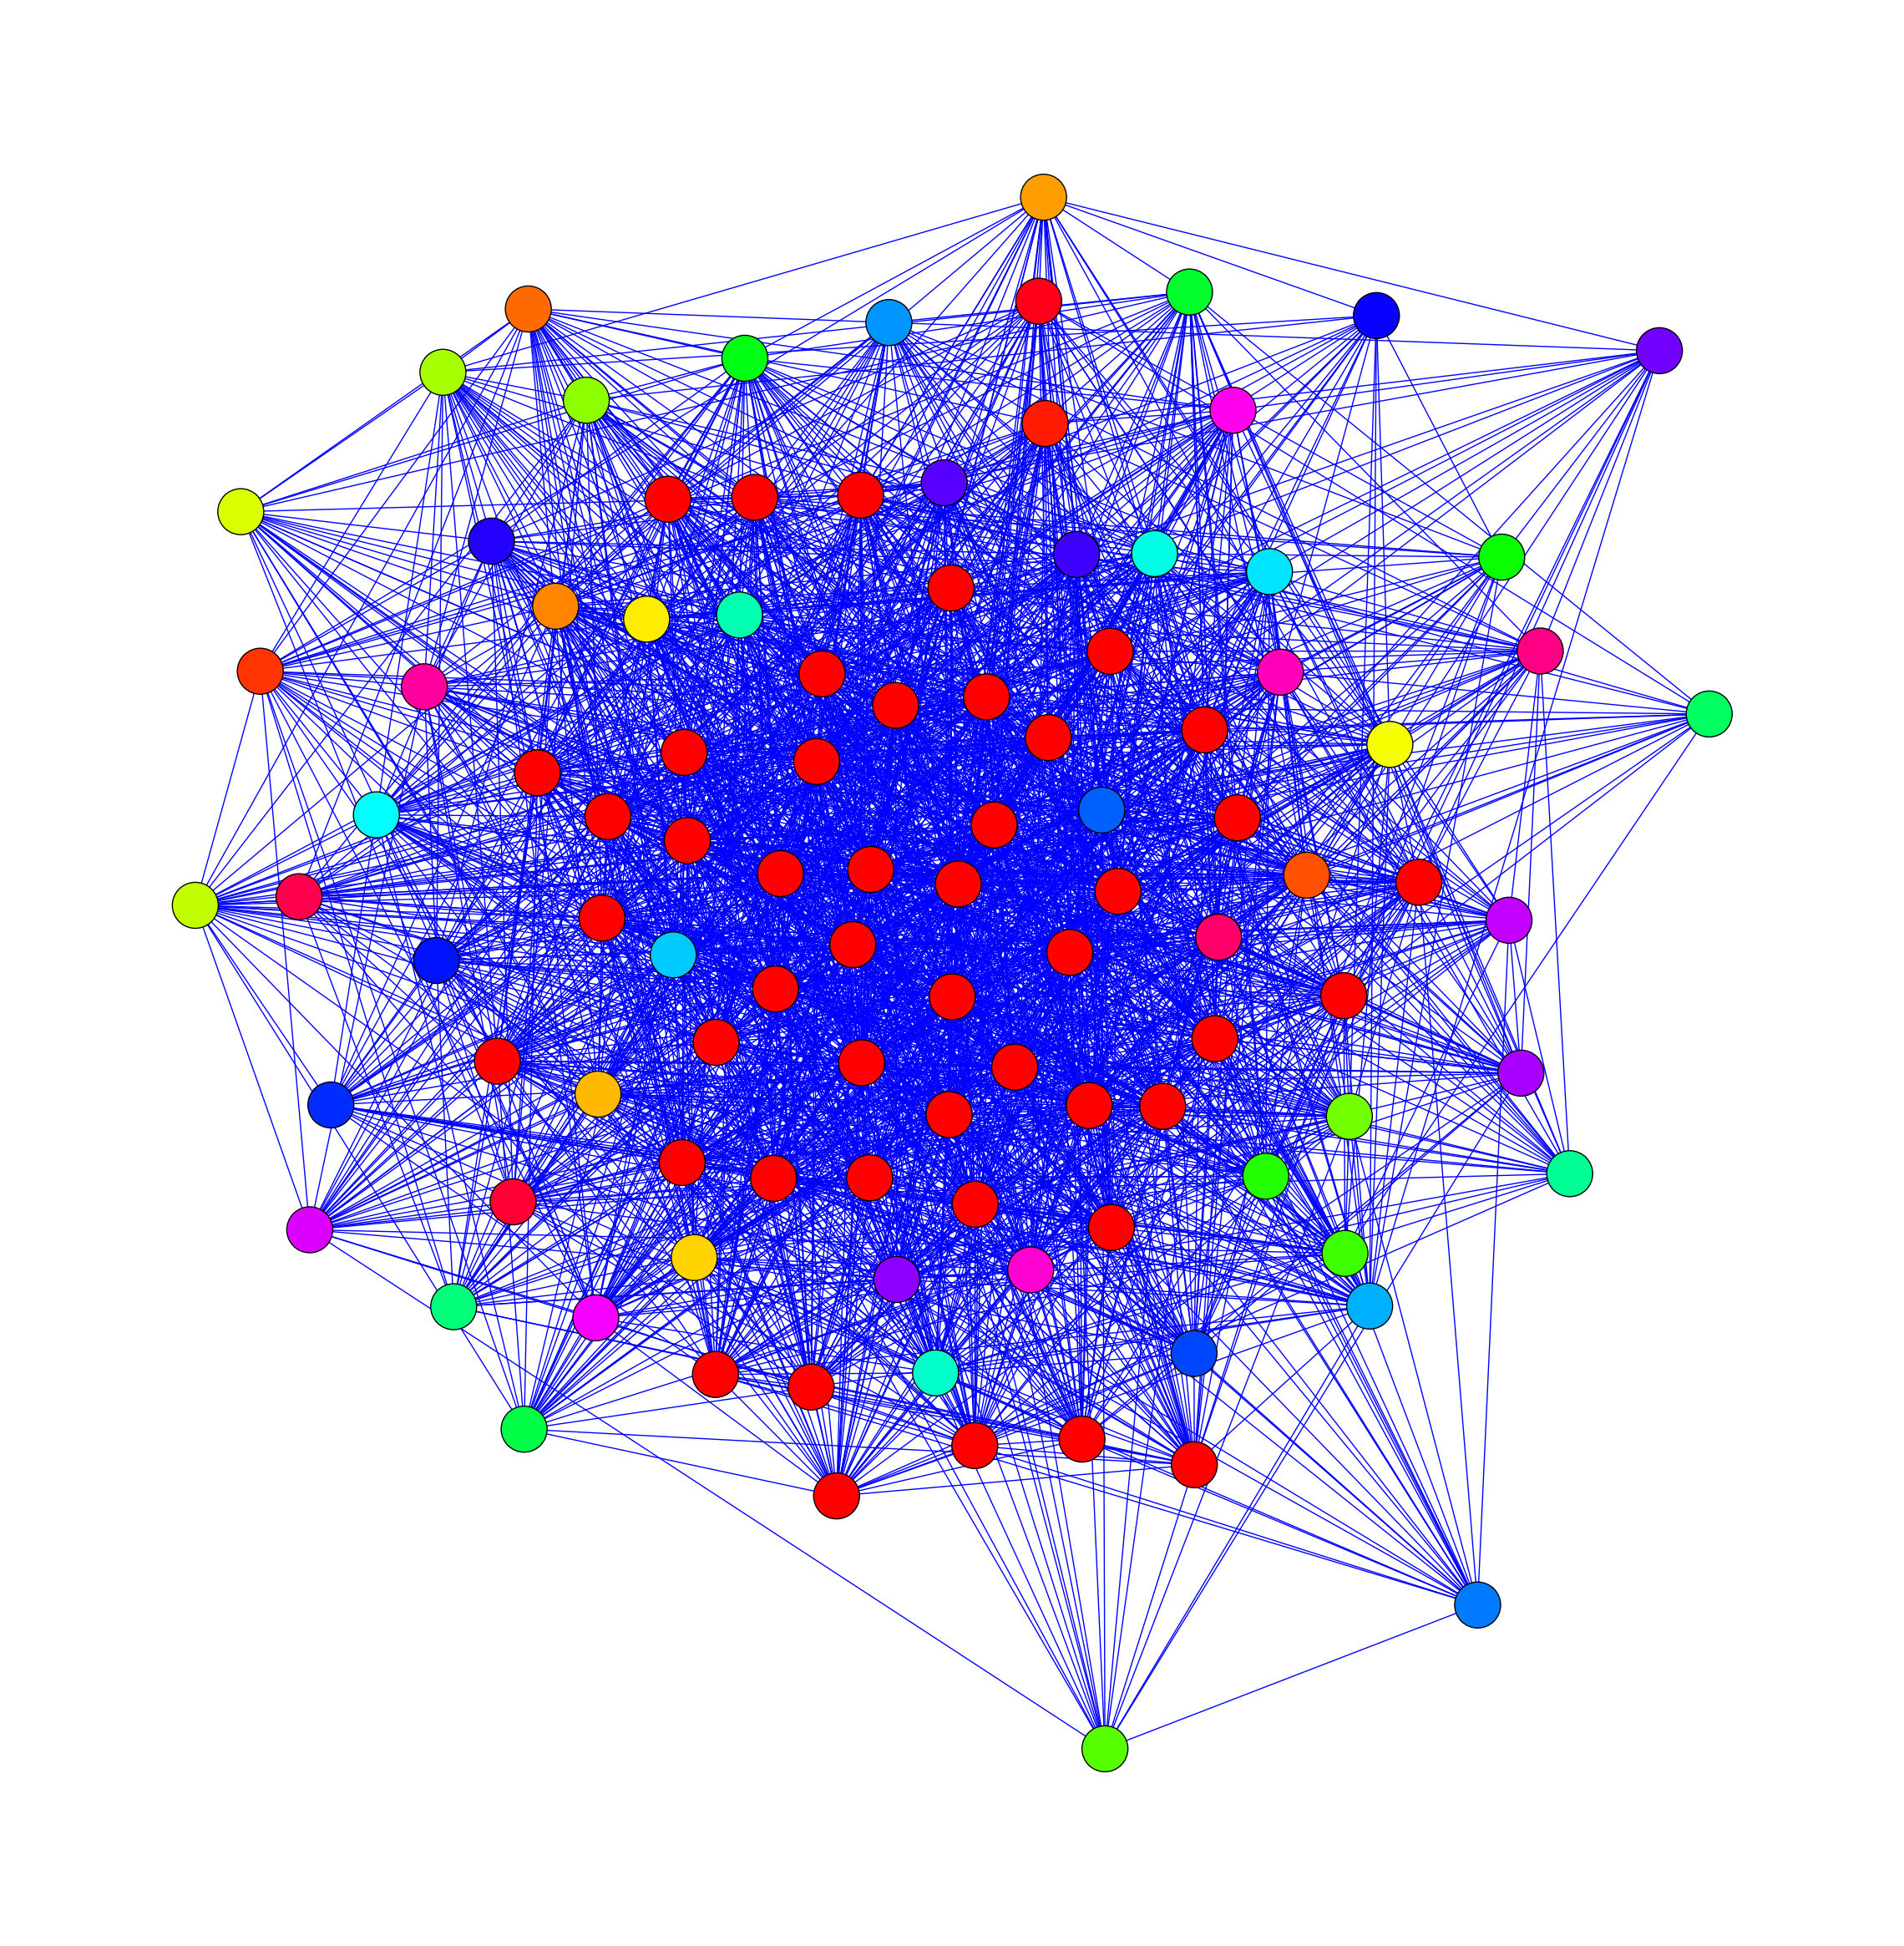

In [42]:
fig, ax = plt.subplots(figsize=(30, 30))
plot(
    communities,
    palette=palette,
    edge_width=1,
    target=ax,
    vertex_size=.1,
)
# remove nodes without edges

# Create a custom color legend
legend_handles = []
""" for i in range(num_communities):
    handle = ax.scatter(
        [], [],
        s=100,
        facecolor=palette.get(i),
        edgecolor="k",
        label=i,
    )
    legend_handles.append(handle)
ax.legend(
    handles=legend_handles,
    title='Community:',
    bbox_to_anchor=(0, 1.0),
    bbox_transform=ax.transAxes,
) """
plt.show()

In [26]:
degree_centrality = net_simp.degree()
betweenness_centrality = net_simp.betweenness()
cluster_coeff = net_simp.transitivity_local_undirected(mode="zero")
# calculate the eigenvector centrality
eigenvector_centrality = net_simp.eigenvector_centrality(directed=False, weights="weight")
# calculate the pagerank
pagerank = net_simp.pagerank(directed=False, weights="weight")
# calculate closeness centrality
closeness_centrality = net_simp.closeness(normalized=True)

In [27]:
# Combine the centrality measures and cluster coefficients into a dictionary
node_metrics = {
    "Degree Centrality": degree_centrality,
    "Betweenness Centrality": betweenness_centrality,
    "Cluster Coefficient": cluster_coeff,
    "Eigenvector Centrality": eigenvector_centrality,
    "PageRank": pagerank,
    "Closeness Centrality": closeness_centrality,
}

In [28]:
# Sort the nodes by the chosen metric (e.g., "Degree Centrality")
sorted_nodes = sorted(range(len(net_simp.vs)), key=lambda x: node_metrics["Degree Centrality"][x], reverse=True)

# Get the top 10 nodes based on the chosen metric
top_10_nodes = sorted_nodes[:10]

print(top_10_nodes)

[17, 63, 77, 26, 56, 80, 100, 6, 71, 50]


In [29]:
# Print the top 10 nodes and their metric values
top_10_data = []
for node in top_10_nodes:
    node_data = {"Node": node}
    for metric_name, metric_values in node_metrics.items():
        node_data[metric_name] = metric_values[node]
    top_10_data.append(node_data)

# Create a DataFrame from the list of dictionaries
top_10_df = pd.DataFrame(top_10_data)

# Print the DataFrame
top_10_df

Node  Degree Centrality  Betweenness Centrality  Cluster Coefficient  \
0    17                 77               64.956099             0.532809   
1    63                 76               78.867041             0.499298   
2    77                 76               77.480129             0.496491   
3    26                 74               78.823310             0.485006   
4    56                 72               65.774987             0.504695   
5    80                 72               69.945619             0.501174   
6   100                 71               64.911701             0.502616   
7     6                 70               67.246529             0.490269   
8    71                 68               61.199290             0.496049   
9    50                 67               55.938387             0.505201   

   Eigenvector Centrality  PageRank  Closeness Centrality  
0                1.000000  0.025130              0.798450  
1                0.627856  0.017165              0.792308  
2                0.758290  0.022005              0.792308  
3                0.658012  0.018202              0.780303  
4                0.434118  0.013882              0.768657  
5                0.660304  0.017287              0.768657  
6                0.536977  0.016901              0.762963  
7                0.424356  0.013954              0.757353  
8                0.476241  0.014381              0.746377  
9                0.652846  0.019292              0.741007

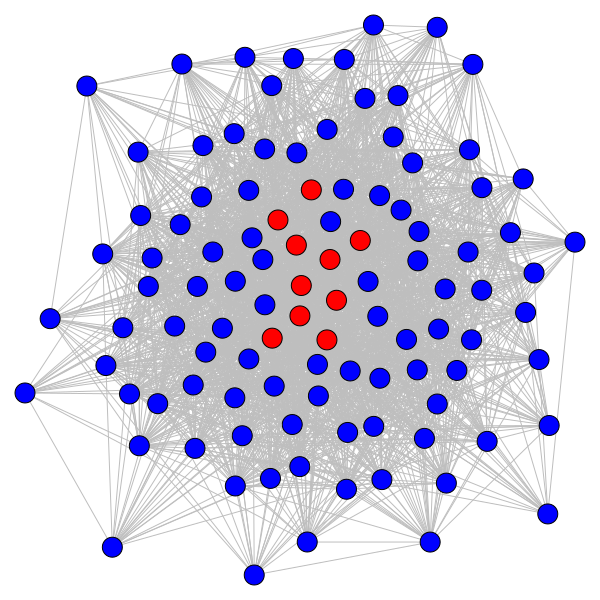

In [30]:
# Create a layout for the graph
layout = net_simp.layout_fruchterman_reingold()

# change edge color
net_simp.es['color'] = 'gray'

# Create a plot and highlight the top 10 nodes using the vertex_color parameter
plot(net_simp, layout=layout, margin=25, edge_arrow_size=0.2, vertex_size=20, bbox=(600, 600), vertex_spacing=350, vertex_color=["red" if v.index in top_10_nodes else "blue" for v in net_simp.vs])

In [31]:
print(f"Number of communities: {num_communities}")

Number of communities: 58


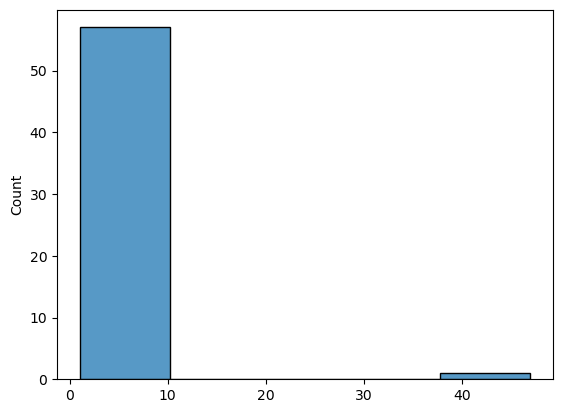

In [32]:
# plot histogram of community sizes
community_sizes = [len(community) for community in communities]
sns.histplot(community_sizes, bins=5);

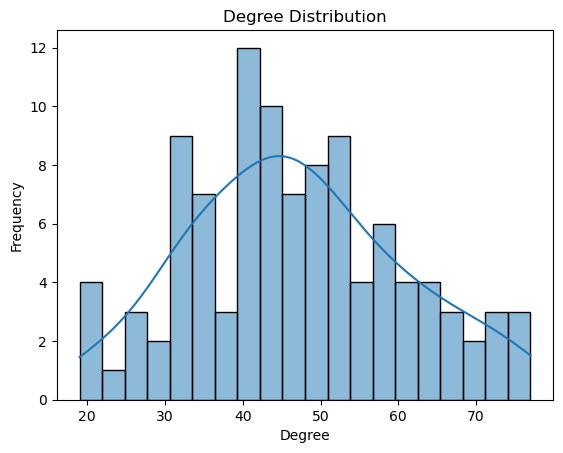

In [33]:
sns.histplot(deg, bins=20, kde=True)
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree Distribution")
plt.show()

Vertices in the largest connected component: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103]


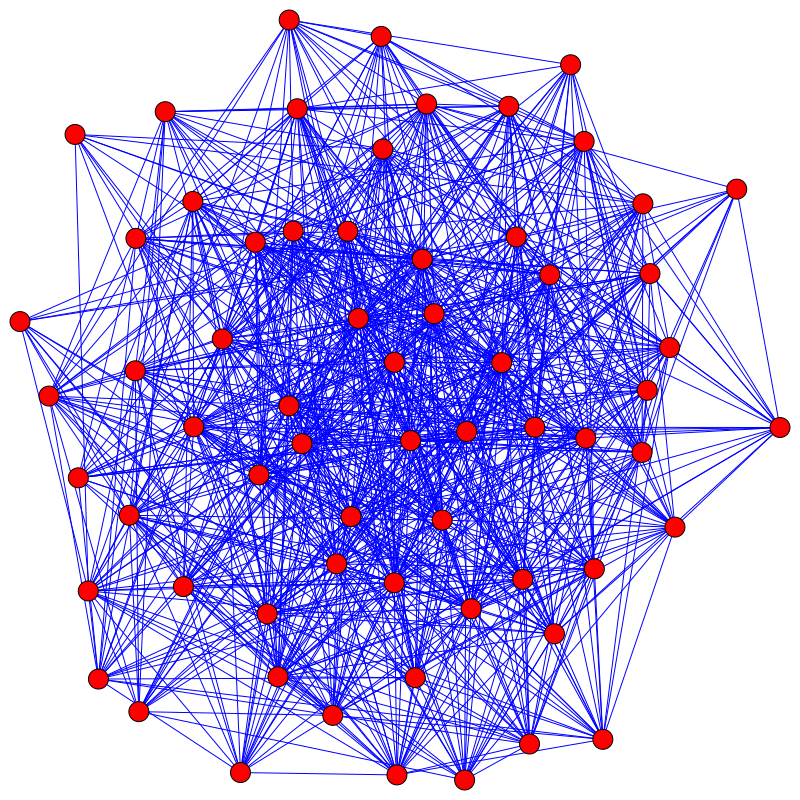

In [34]:
# Find connected components
components = net.components()

# Get the largest connected component
largest_component = max(components, key=len)

# Perform any analysis on the largest connected component
print("Vertices in the largest connected component:", largest_component)

# change color of nodes in largest component
net.vs["color"] = ["red" if v.index in largest_component else "blue" for v in net.vs]

# change color of edges in largest component
net.es["color"] = ["blue" if e.source in largest_component and e.target in largest_component else "red" for e in net.es]

# Plot the largest connected component
plot(net.subgraph(largest_component[0:65]), bbox=(800, 800), vertex_spacing=250)